What is the Idea of Cartpole Game -> The Agent has to decide between two actions - Moving the cart to Left or Right - so that the Pole Attached To Stays Upright.

In [1]:
import gymnasium as gym

import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
is_ipython = 'inline' in matplotlib.get_backend().lower()

if is_ipython:
    from IPython import display

plt.ion()

In [5]:
device = torch.device("cude" if torch.cuda.is_available() else "cpu")

In [6]:
env = gym.make("CartPole-v1")

In [7]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

### Our Transitions && Replay Memory

- Transition - is a named Tuple Consist of 4 values (state, action, next_state, reward)
- ReplayMemory - Push Every Transition To Memory

In [8]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        """
        Save a Transition
        """
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### DQN Algorithm

- DQN - (Deep Q-Network) - Is a Reinforcement Learning Algorithm that uses Deep Neural Networks To Approximate the Q-Function in Q-Learning Algorithm.

Our Model will be a Convolutional Neural Network that takes in the difference between the current and orevious screen patches. It has two outputs, representing ``` Q(s, left) ``` and ``` Q(s, right) ``` (where s is the input to the Network). In effect, the network is trying to predict the expected return of taking each action given the current input...

In [9]:
class DQN(nn.Module):
    ## Multi-Layer Perceptron With Three Layers
    ## n_observation is the input(state of the environment) to the network
    ## n_actions - Number of possible actions in the environment
    def __init__(self, n_observation, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observation, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    ## Take and Pass the 3 Layers To the Neural Network
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Train The DQN

In [10]:
BATCH_SIZE = 128  # No. Of Transition Samples from The Replay Buffer
GAMMA = 0.99      # Is The Discount Factor
EPS_START = 0.9   # Epsilon Starting Value
EPS_END = 0.05    # Epsilon Ending Value
EPS_DECAY = 1000  # Epsilon Decay Value - Conrols the Exp. Decay of Epsilon - Higher Val -> Slower Decay
TAU = 0.005       # Update Rate of the Target Network
LR = 1e-4         # Learning Rate of Adam Optimizer


In [11]:
## Get Number of Action From GYM Action Space
n_actions = env.action_space.n

## Get the number of state observation
state, info = env.reset()

## Get the number of features in the state
n_observations = len(state)

## target_net is initialized with same weight as policy_net
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

## Our Optimizer - AdamW Uses To Optimize The Weights - Enhanced Version of SGD
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

## It Will store the Agent's Experiences, Which will be used during The Trsining Process
memory = ReplayMemory(10000)

In [12]:
## Keep Track of Number of Steps Taken By the Agent
steps_done = 0

## Input - Current State and Return an Action ??
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            """
            t.max(1) will return the largest column value of each raw
            second column on max result is the index of where max element was found
            so we pick action with the largest excepeted reward
            """
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

In [ ]:
## Is Used To Keep Track of the Duration of Each Episode
episode_durations = []

## Visulaize the Training Process
def plot_durations(show_result=False):
    plt.figure(1)
    duration_t = torch.tensor(episode_durations, dtype=torch.long)
    
    if show_result:
        plt.title("Final Result")
    else:
        plt.clf()
        plt.title("Training")
    
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(duration_t.numpy())
    
    if len(duration_t) >= 100:
        means = duration_t.float().unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        
        plt.plot(means.numpy())
    
    plt.pause(0.001)  # So That Plot are Updated
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [20]:
def optimize_model():
    ## Chack if we have enough sample for a mini-batch
    if len(memory) < BATCH_SIZE:
        return
    
    ## Extract a mini-batch of transition(state, action, next_state, reward) from replay memory
    transition = memory.sample(BATCH_SIZE)
    
    ## Convert Batch-Array of Transitions to Transition Of batch arrays
    batch = Transition(*zip(*transition))
    
    ## Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_mask).max(1)[0]
    
    ## Except Q-Value for each Tranision Using the Target
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    ## Compute Huber Loss - Smooth Approximantion of the mean squared error loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    ## Optimize the Model
    optimizer.zero_grad()
    loss.backward()
    
    ## In-Place Gradient Clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters())
    optimizer.step()

✅ Completed


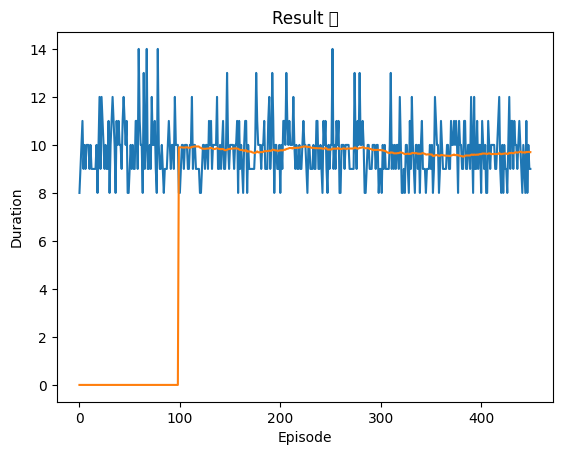

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 450

for i_episode in range(num_episodes):
    ## Initialize the Environment and Get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action=action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated | truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        ## Store The Transition
        memory.push(state, action, next_state, reward)
        
        ## Move To the Next State
        state = next_state
        
        optimize_model
        
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    
    print("✅ Completed")
    
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()